In [ ]:
! pip install -U langchain openai chromadb pypdfium2

## Load

In [23]:
import pypdfium2 as pdfium

def get_images(fpath,fname):
    """
    Get PIL images from PDF pages
    """
    pdf = pdfium.PdfDocument(fpath + fname)
    n_pages = len(pdf)
    pil_images = []
    for page_number in range(n_pages):
        page = pdf.get_page(page_number)
        bitmap = page.render(scale = 1, rotation = 0, crop=(0, 0, 0, 0))
        pil_image = bitmap.to_pil() 
        pil_images.append(pil_image)
    return pil_images

fpath = "/Users/rlm/Desktop/Eval_Sets/multi_modal_presentations/DDOG/"
fname = "DDOG_Q3_earnings_deck.pdf"
pil_images = get_images(fpath,fname)

In [25]:
import base64
from io import BytesIO

def convert_to_base64(pil_image):
    """
    Base64 encoded strings
    """
    
    buffered = BytesIO()
    pil_image.save(buffered, format="JPEG")  # You can change the format if needed
    img_str = base64.b64encode(buffered.getvalue()).decode("utf-8")
    return img_str

images_base_64 = [convert_to_base64(i) for i in pil_images]


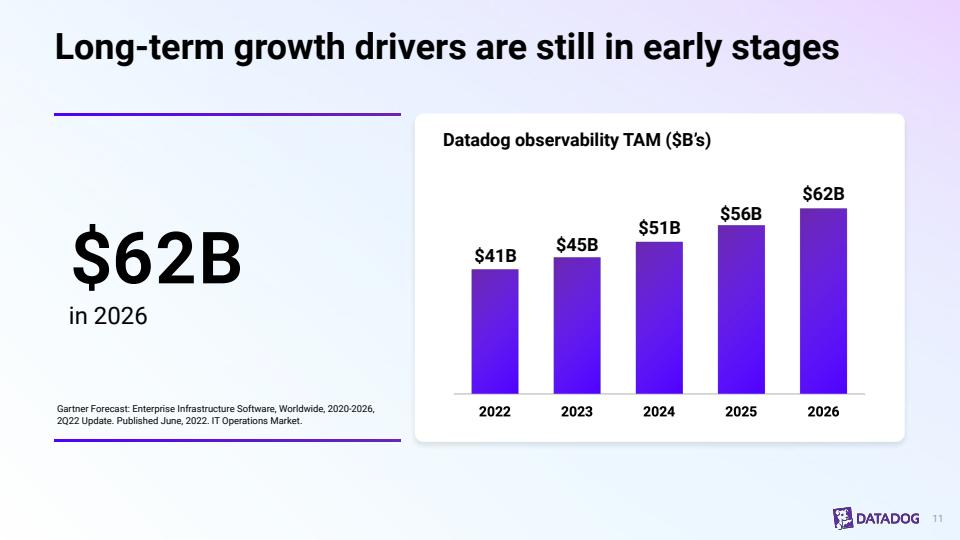

In [40]:
from PIL import Image
from IPython.display import HTML, display
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough

def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))

i = 10
plt_img_base64(images_base_64[i])

## Summarize Images

In [31]:
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser
from langchain.schema.messages import HumanMessage

def image_summarize(img_base64, prompt):
    """Make image summary"""
    chat = ChatOpenAI(model="gpt-4-vision-preview", max_tokens=1024)

    msg = chat.invoke(
        [
            HumanMessage(
                content=[
                    {"type": "text", "text": prompt},
                    {
                        "type": "image_url",
                        "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"},
                    },
                ]
            )
        ]
    )
    return msg.content

def generate_img_summaries(img_base64_list):
    """
    Generate summaries and base64 encoded strings for images
    img_base64_list: Base64 encoded images
    """

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for i, base64_image in enumerate(img_base64_list):
        try:
            image_summaries.append(image_summarize(base64_image, prompt))
        except:
            print("Error on image: %s"%str(i+1))

    return image_summaries

# Image summaries
image_summaries = generate_img_summaries(images_base_64)

Error on image: 12
Error on image: 15


In [35]:
### To Do: Debug why we see the OAI BadRequestError on some images 
### Hack for now
indices_to_remove = {11, 14}  # use a set for faster lookup
images_base_64 = [item for idx, item in enumerate(images_base_64) if idx not in indices_to_remove]

## Make Retriever

Add raw docs and doc summaries to [Multi Vector Retriever](https://python.langchain.com/docs/modules/data_connection/retrievers/multi_vector#summary): 

* Store the raw images in the `docstore`.
* Store the image summaries in the `vectorstore` for semantic retrieval.

In [38]:
import uuid

from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma


def create_multi_vector_retriever(
    vectorstore, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    add_documents(retriever, image_summaries, images)

    return retriever

# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="multi-modal-rag", 
    embedding_function=OpenAIEmbeddings()
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    image_summaries,
    images_base_64,
)

## RAG

In [39]:
import io
import re

from IPython.display import HTML, display
from langchain.schema.runnable import RunnableLambda, RunnablePassthrough
from PIL import Image


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xFF\xD8\xFF": "jpg",
        b"\x89\x50\x4E\x47\x0D\x0A\x1A\x0A": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOpenAI(temperature=0, model="gpt-4-vision-preview", max_tokens=1024)

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain

# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

## Test

In [41]:
chain_multimodal_rag.invoke("What is the projected TAM over time for observability?")

"Based on the first image provided, the projected Total Addressable Market (TAM) for observability, as estimated by Datadog, is expected to grow over time as follows:\n\n- In 2022, the TAM is $41 billion.\n- In 2023, the TAM is projected to increase to $45 billion.\n- In 2024, the TAM is expected to grow to $51 billion.\n- In 2025, the projection is $56 billion.\n- By 2026, the TAM is anticipated to reach $62 billion.\n\nThis data suggests a steady growth trajectory for the observability market, indicating that it could be a growing sector with increasing investment opportunities over the next few years. If you are considering investment in this space, it may be worthwhile to look into companies that are well-positioned to capitalize on this growth, such as those that provide observability solutions and services. However, it's important to conduct thorough due diligence and consider other financial metrics and market factors before making any investment decisions."

See [trace](https://smith.langchain.com/public/21c61c87-2bdd-4c38-9967-b9df9f5549fb/r).